In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.append('../')

from implementations import *

%load_ext autoreload
%autoreload 2

# **Load and clean the training data**

We load the training data.

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


For each feature, we clean the data so the values make more sense

We then clean the data by : 
- selecting the best 43 features with human decision and correlation analysis
- removing the nan values by the median of the rest of the feature for continuous values
- removing the nan values by the -1 for categorical features
- removing the features where the variance is zero since they are constants for all samples

In [3]:
cont_data = [13, 15, 16, 17, 24 ,25 ,26 ,27 ,28 ,29 ,33 ,37,49 ,59 ,60 ,62 ,63 ,75 ,77 ,78 ,
             79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,89 ,90 ,92 ,93 ,94, 98 ,110 ,111 ,112 ,113 ,114 ,143
            ,147 ,148 ,149 ,150 ,168 ,195 ,197 , 206 ,207 ,208 ,209 ,210 ,211 ,212 ,213 ,219, 220, 221
            ,222, 226, 228, 229, 248 ,250 ,251 ,252 ,253 ,262 ,264 ,266,267,268,269,270,271,276,277,285,286,287,288,291,292, 293,294, 295, 296, 297, 299, 300, 301, 302, 303, 304]

# Generate a list of all indices from 1 to 320
all_indices = list(range(0, 321))

# Use a list comprehension to filter out indices not in your array
cat_data = [idx for idx in all_indices if idx not in cont_data]

In [4]:
xt_feat = x_train.copy()
xt_feat = preprocessing(xt_feat)
xt_feat = gen_clean(xt_feat, cat_data, cont_data)
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 321 features !


In [5]:
pca_indices, idx = pca(xt_feat)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 37 first most influent features given by pca_indices


In [6]:
x_train_pca = xt_feat[:, pca_indices]
x_train_pca = x_train_pca[:, :idx]

print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 37 features


# Linear regression 

We train our model using linear regression with mean-square error.

First, we separate our data in a training set(70%) and testing set(30%).

In [7]:
tx_tr, tx_te, y_tr, y_te = cross(xt_feat, y_train, 0.8)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (262508, 321) ; tx_te shape : (65627, 321)
       y_tr : (262508,)     ;        y_te : (65627,)


Now we build our models for linear regression

In [8]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 322 features !


## Training

Here we train our model using GD with MSE

In [22]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 2.41e-5

start_time = datetime.datetime.now()
w, loss = mean_squared_error_gd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 14.831732 seconds


In [23]:
print(loss)

0.16520995078313422


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

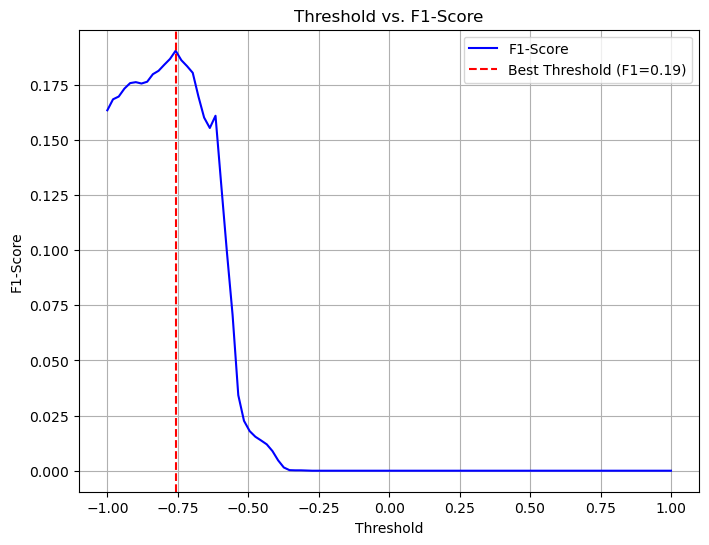

In [24]:
best_thresh = best_threshold(y, tx, w)

In [25]:
pred_data = np.dot(tx, w)

pred_data[pred_data > best_thresh] = 1
pred_data[pred_data <= best_thresh] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 50.57902997241989%
Precision: 11.12626144782127%
Recall : 66.03340834343085%
F1-score : 19.043756084167438%


Now we compute some metrics for our test data (40% of the total data)

In [16]:
pred_test = np.dot(tx_test, w)

pred_test[pred_test > best_thresh] = 1
pred_test[pred_test <= best_thresh] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 50.313133314032335%
Precision: 11.225821419250066%
Recall : 65.97920572694733%
F1-score : 19.18711276332094%


### Feature analysis

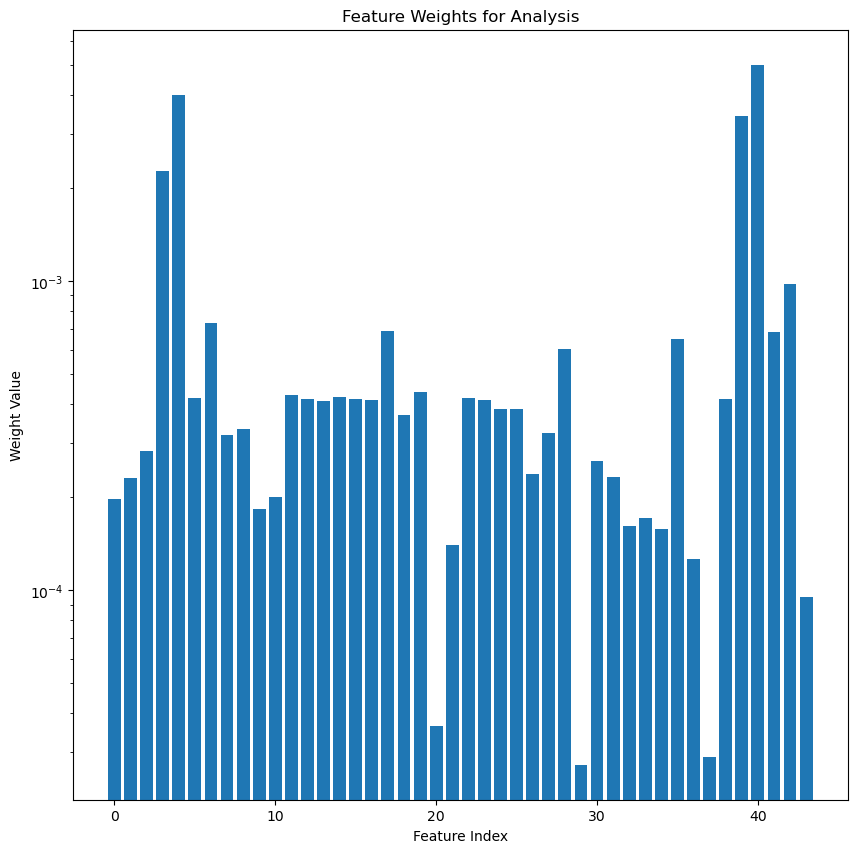

In [13]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# **Prediction on test data**

In [40]:
start_time = datetime.datetime.now()

tx_test = gen_clean(x_test, feat_cat, feat_con)
tx_test = tx_test[:, feat]
tx_te = np.c_[np.ones(tx_test.shape[0]), tx_test]

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")
print(f"The data has {tx_test.shape[0]} samples and {tx_test.shape[1]} features !")

Execution time 0.387158 seconds
The data has 109379 samples and 43 features !


In [45]:
pred_te = np.dot(tx_te, w)

pred_te[pred_te > 0] = 1
pred_te[pred_te < 0] = -1

indices_one = np.where(pred_te == 1)

In [46]:
create_csv_submission(test_ids, pred_te, "../data/lin_reg.csv")